[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/git-sunao/path-integral/blob/main/notebooks/dev04.ipynb)

In [1]:
# Run this if in Google Colab
# !git clone https://github.com/git-sunao/path-integral.git
# %cd path-integral
# !pip install -r requirements.txt

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import jacobian
from getdist import MCSamples, plots

from tqdm import tqdm

import sys
sys.path.append("../")

from pldflow import plflow

import os
import jax
smoke_test = ('CI' in os.environ)
%matplotlib inline
cpu_device = jax.devices('cpu')[0]

/Users/sugiyamasunao/miniconda3/envs/pyplint/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
class Fresnel(plflow.PicardLefschetzModelBaseClass):
    ndim = 1
    def action_s(self, z, y, p=1):
        return 1j*jnp.dot(z, z) - 2j*jnp.dot(z, y)

In [5]:
fresnel = Fresnel()

# Debugging

In [6]:
n_samples = 200
# integral variable
x1 = jnp.linspace(-5, 5, n_samples)
x2 = jnp.zeros((n_samples, fresnel.ndim-1))
x  = jnp.array([x1, *x2.T]).T
# parameter
y  = jnp.zeros(fresnel.ndim)
# flow time
# t = jnp.linspace(0, 1.0, 1000)
# t = jnp.linspace(0, 0.5, 100)
# t = jnp.linspace(0, 1e-3, 100)
# t = jnp.linspace(0, 1.0, 4)
t = jnp.linspace(0, 0.4, 100)


In [7]:
%time j = fresnel.vflow_jacobian(x, t, y=y, uselast=True)
%time j = fresnel.vflow_jacobian(x, t, y=y, uselast=True)

CPU times: user 454 ms, sys: 39.6 ms, total: 494 ms
Wall time: 480 ms
CPU times: user 1.75 ms, sys: 99 µs, total: 1.85 ms
Wall time: 1.6 ms


In [8]:
%time ja= fresnel.vflow_jacobian_approx(x, t, y=y, uselast=True, withz=False)
%time ja= fresnel.vflow_jacobian_approx(x, t, y=y, uselast=True, withz=False)

CPU times: user 238 ms, sys: 16.7 ms, total: 254 ms
Wall time: 248 ms
CPU times: user 2.93 ms, sys: 154 µs, total: 3.09 ms
Wall time: 2.77 ms


In [9]:
j.shape, ja.shape

((200,), (200,))

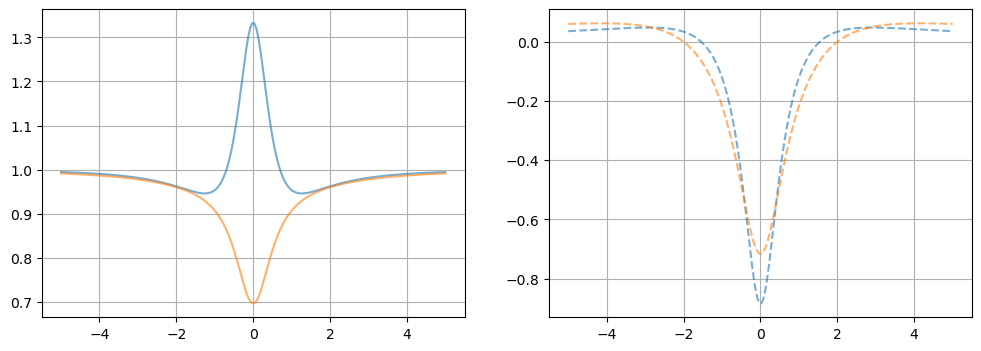

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(x[:,0], j.real , label='exact' , color='C0', alpha=0.6)
axes[0].plot(x[:,0], ja.real, label='approx', color='C1', alpha=0.6)
axes[0].grid()
axes[1].plot(x[:,0], j.imag , label='exact' , color='C0', ls='--', alpha=0.6)
axes[1].plot(x[:,0], ja.imag, label='approx', color='C1', ls='--', alpha=0.6)
axes[1].grid()
plt.show()

## Plotting gif

In [11]:
# fresnel.plot1dgif('temp.gif', x, t, y=y)

## Sampling

In [12]:
fresnel = Fresnel(ndim=5)
fresnel.rescale_velocity = False
t = jnp.linspace(0, 0.5, 100)

priors = {'x':(-5,5,fresnel.ndim), 'y':(-5,5,fresnel.ndim)}
sampler = plflow.HMCSampler(fresnel, priors)
sampler.sample(num_samples=10000, t=t)

/Users/sugiyamasunao/miniconda3/envs/pyplint/lib/python3.11/site-packages/jax/_src/lax/lax.py:2803: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)
sample: 100%|██████████| 10500/10500 [00:12<00:00, 813.53it/s, 63 steps of size 6.01e-02. acc. prob=0.91]  


Removed no burn in


<Figure size 400x400 with 0 Axes>

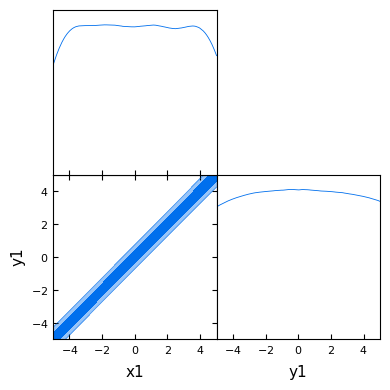

In [12]:
mcs = sampler.get_samples(format=MCSamples)

g = plots.get_single_plotter(ratio=1, width_inch=4)
g.triangle_plot(mcs, ['x1', 'y1'], filled=True)
plt.show()

## Normalizing flow training

Training MAF:  32%|███▏      | 317/1000 [01:24<03:03,  3.73it/s] 


Early stopping at step 318 with best loss -3.535677909851074


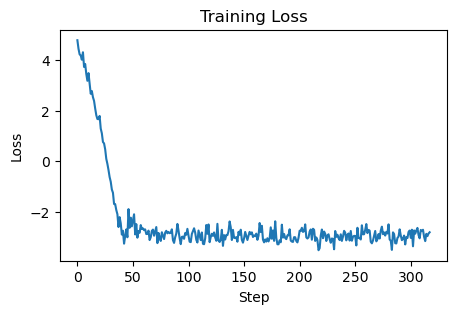

In [13]:
maf = plflow.MAFModel(sampler, process=True)

maf.build(hidden_dims=[128]*4, n_transforms=12)
maf.train(n_steps=1_000, batch_size=128, patience=100)
maf.plot_loss()

CPU times: user 242 ms, sys: 28.6 ms, total: 270 ms
Wall time: 63 ms
CPU times: user 1.63 s, sys: 170 ms, total: 1.8 s
Wall time: 399 ms


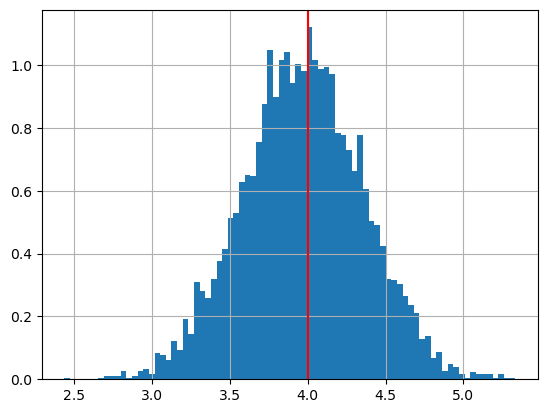

In [15]:
y = jnp.array([4.0]+[0.0]*(fresnel.ndim-1))
%time x = maf.sample(y, num_samples=5000, seed=5)
%time lnp = maf.log_prob(x, y)

a = jnp.argsort(x[:,0])
plt.hist(x[a,0], bins=80, density=True)
plt.axvline(y[0], color='r')
plt.grid()
plt.show()

## Evaluate the integral

In [16]:
y1 = jnp.linspace(-3, 3, 100)
y2 = jnp.zeros_like(y1)
y  = jnp.stack([y1]+[y2]*(fresnel.ndim-1), axis=1)

Z = []
for _y in tqdm(y):
    x = maf.sample(_y, num_samples=1000, seed=0, beta=1.0)
    lnp = maf.log_prob(x, _y, beta=1.0)
    _Z = fresnel.integrate(x, lnp, t, y=_y)
    Z.append(_Z)
Z = jnp.array(Z)

100%|██████████| 100/100 [00:22<00:00,  4.43it/s]


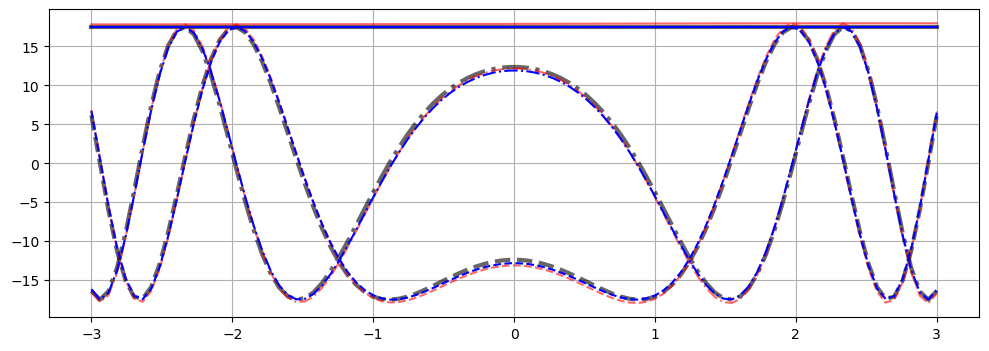

In [17]:
# Get analytic result
ndim = fresnel.ndim
Z_ana = jnp.exp(1j*y1**2) * ((1-1j)*jnp.sqrt(jnp.pi/2.0))**ndim

# Plotting
plt.figure(figsize=(12, 4))
# analytic
plt.plot(y1, jnp.real(Z_ana), color='k', ls='--', alpha=0.6, lw=3)
plt.plot(y1, jnp.imag(Z_ana), color='k', ls='-.', alpha=0.6, lw=3)
plt.plot(y1, jnp.abs(Z_ana) , color='k', ls='-' , alpha=0.6, lw=3)
# estimate
plt.plot(y1, jnp.real(Z), color='r', ls='--', alpha=0.6)
plt.plot(y1, jnp.imag(Z), color='r', ls='-.', alpha=0.6)
plt.plot(y1, jnp.abs(Z) , color='r', ls='-' , alpha=0.6)
# abs corrected
norm = jnp.abs(Z)/jnp.abs(Z_ana)
plt.plot(y1, jnp.real(Z)/norm, color='b', ls='--')
plt.plot(y1, jnp.imag(Z)/norm, color='b', ls='-.')
plt.plot(y1, jnp.abs(Z) /norm, color='b', ls='-')
plt.grid()
plt.show()

# Higher dimension

In [28]:
fresnel = Fresnel(ndim=10)
fresnel.rescale_velocity = False
t = jnp.linspace(0, 0.5, 100)

priors = {'x':(-5,5,fresnel.ndim), 'y':(-5,5,fresnel.ndim)}
sampler = plflow.HMCSampler(fresnel, priors)
sampler.sample(num_samples=10000, t=t)

/Users/sugiyamasunao/miniconda3/envs/pyplint/lib/python3.11/site-packages/jax/_src/lax/lax.py:2803: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)
sample: 100%|██████████| 10500/10500 [00:25<00:00, 409.88it/s, 127 steps of size 5.18e-02. acc. prob=0.90]


Removed no burn in


<Figure size 400x400 with 0 Axes>

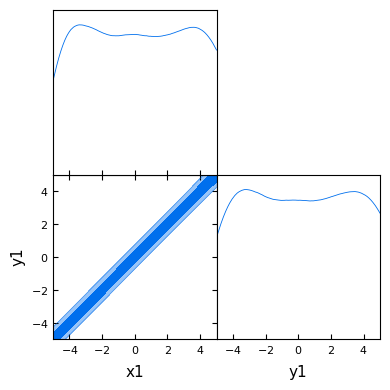

In [29]:
mcs = sampler.get_samples(format=MCSamples)

g = plots.get_single_plotter(ratio=1, width_inch=4)
g.triangle_plot(mcs, ['x1', 'y1'], filled=True)
plt.show()

Training MAF:   0%|          | 0/1000 [00:00<?, ?it/s]2025-01-02 21:40:23.928459: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 2m16.69117s

********************************
[Compiling module jit_step] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
Training MAF:  25%|██▌       | 254/1000 [03:35<10:33,  1.18it/s]  


Early stopping at step 255 with best loss -6.597610950469971


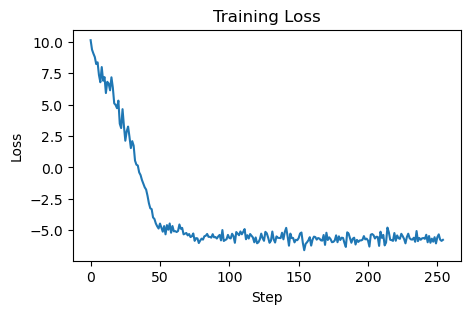

In [30]:
maf = plflow.MAFModel(sampler, process=True)

# maf.build(hidden_dims=[128]*3, n_transforms=12)
maf.build(hidden_dims=[200]*3, n_transforms=12)
maf.train(n_steps=1_000, batch_size=128, patience=100)
maf.plot_loss()

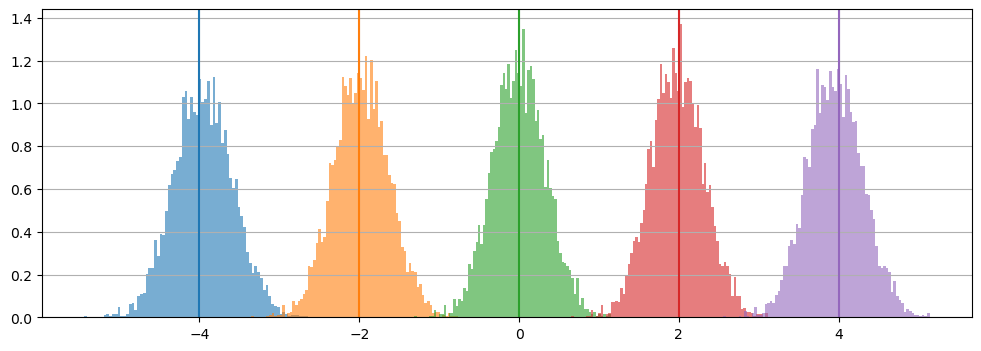

In [32]:
plt.figure(figsize=(12, 4))
for i, _y in enumerate([-4.0, -2.0, 0.0, 2.0, 4.0]):
    y   = jnp.array([_y]+[0.0]*(fresnel.ndim-1))
    x   = maf.sample(y, num_samples=5000, seed=5)
    lnp = maf.log_prob(x, y)
    a = jnp.argsort(x[:,0])
    plt.hist(x[a,0], bins=80, density=True, color=f'C{i}', alpha=0.6)
    plt.axvline(y[0], color=f'C{i}')
plt.grid()
plt.show()

In [33]:
y1 = jnp.linspace(-3, 3, 100)
y2 = jnp.zeros_like(y1)
y  = jnp.stack([y1]+[y2]*(fresnel.ndim-1), axis=1)

Z = []
for _y in tqdm(y):
    x = maf.sample(_y, num_samples=1000, seed=0, beta=1.0)
    lnp = maf.log_prob(x, _y, beta=1.0)
    _Z = fresnel.integrate(x, lnp, t, y=_y)
    Z.append(_Z)
Z = jnp.array(Z)

100%|██████████| 100/100 [00:42<00:00,  2.37it/s]


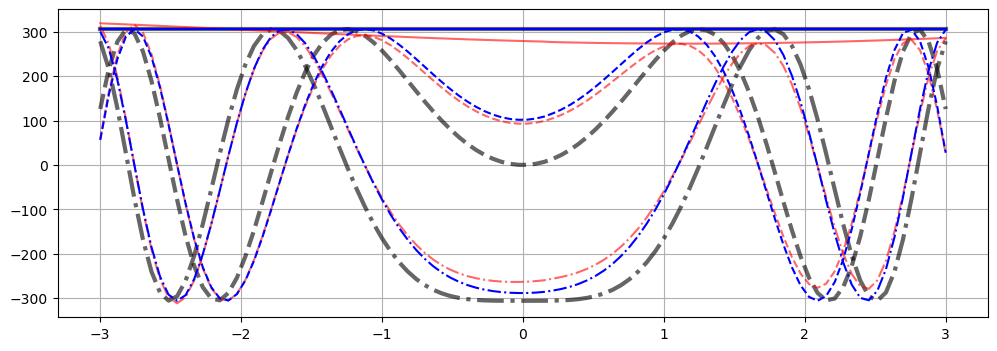

In [34]:
# Get analytic result
ndim = fresnel.ndim
Z_ana = jnp.exp(1j*y1**2) * ((1-1j)*jnp.sqrt(jnp.pi/2.0))**ndim

# Plotting
plt.figure(figsize=(12, 4))
# analytic
plt.plot(y1, jnp.real(Z_ana), color='k', ls='--', alpha=0.6, lw=3)
plt.plot(y1, jnp.imag(Z_ana), color='k', ls='-.', alpha=0.6, lw=3)
plt.plot(y1, jnp.abs(Z_ana) , color='k', ls='-' , alpha=0.6, lw=3)
# estimate
plt.plot(y1, jnp.real(Z), color='r', ls='--', alpha=0.6)
plt.plot(y1, jnp.imag(Z), color='r', ls='-.', alpha=0.6)
plt.plot(y1, jnp.abs(Z) , color='r', ls='-' , alpha=0.6)
# abs corrected
norm = jnp.abs(Z)/jnp.abs(Z_ana)
plt.plot(y1, jnp.real(Z)/norm, color='b', ls='--')
plt.plot(y1, jnp.imag(Z)/norm, color='b', ls='-.')
plt.plot(y1, jnp.abs(Z) /norm, color='b', ls='-')
plt.grid()
plt.show()

In [35]:
y1 = jnp.linspace(-3, 3, 100)
y2 = jnp.zeros_like(y1)
y  = jnp.stack([y1]+[y2]*(fresnel.ndim-1), axis=1)

Z = []
for _y in tqdm(y):
    # x = maf.sample(_y, num_samples=1000, seed=0, beta=1.0)
    x = maf.sample(_y, num_samples=300, seed=0, beta=1.0)
    lnp = maf.log_prob(x, _y, beta=1.0)
    _Z = fresnel.integrate_approx(x, lnp, t, y=_y)
    Z.append(_Z)
Z = jnp.array(Z)

100%|██████████| 100/100 [00:28<00:00,  3.49it/s]


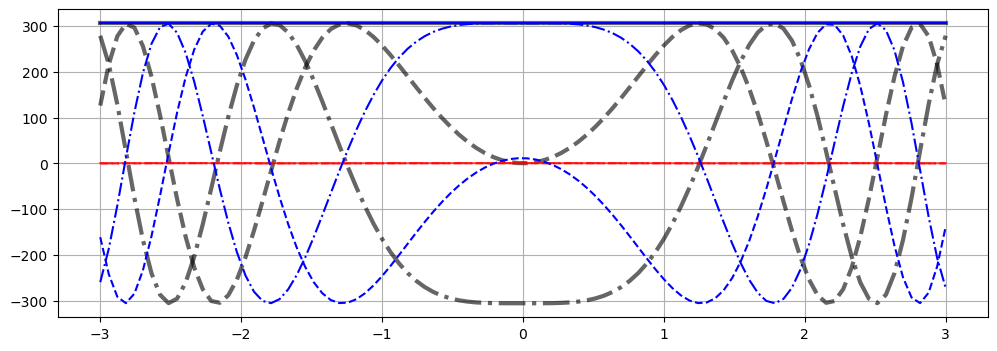

In [36]:
# Get analytic result
ndim = fresnel.ndim
Z_ana = jnp.exp(1j*y1**2) * ((1-1j)*jnp.sqrt(jnp.pi/2.0))**ndim

# Plotting
plt.figure(figsize=(12, 4))
# analytic
plt.plot(y1, jnp.real(Z_ana), color='k', ls='--', alpha=0.6, lw=3)
plt.plot(y1, jnp.imag(Z_ana), color='k', ls='-.', alpha=0.6, lw=3)
plt.plot(y1, jnp.abs(Z_ana) , color='k', ls='-' , alpha=0.6, lw=3)
# estimate
plt.plot(y1, jnp.real(Z), color='r', ls='--', alpha=0.6)
plt.plot(y1, jnp.imag(Z), color='r', ls='-.', alpha=0.6)
plt.plot(y1, jnp.abs(Z) , color='r', ls='-' , alpha=0.6)
# abs corrected
norm = jnp.abs(Z)/jnp.abs(Z_ana)
plt.plot(y1, jnp.real(Z)/norm, color='b', ls='--')
plt.plot(y1, jnp.imag(Z)/norm, color='b', ls='-.')
plt.plot(y1, jnp.abs(Z) /norm, color='b', ls='-')
plt.grid()
plt.show()